In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import re
import string
from wordcloud import STOPWORDS

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Data collection script

# // Self loading
# function loadMore() { 
#     setTimeout(function() {   
#         // save button information to variable, update each iteration
#         var button = document.getElementById('load-more-trigger');
#         var style = window.getComputedStyle(button);
#         visible = style.getPropertyValue('display');
#         // scroll to bottom of page (force reviews to load)
#         window.scrollTo(0, document.body.scrollHeight);
#         if (visible != 'none') {      
#             button.click();                  
#             loadMore();            
#         }
#         else {
#             getData();
#         }                  
#     }, 3000); // set delay to 3 seconds
# }
#
# function getData() {
#     // Collect reviews
#     let reviews = document.getElementsByClassName('lister-item-content');
#
#     let review_data = [];
#
#     for (let i = 0; i < reviews.length; i++) {
#         if (reviews[i].getElementsByClassName('rating-other-user-rating').length > 0) {
#             review = {
#                 'movie': document.getElementsByClassName('subnav_heading')[0].text,
#                 'user': reviews[i].getElementsByClassName('display-name-link')[0].innerText,
#                 'date': reviews[i].getElementsByClassName('review-date')[0].innerText,
#                 // Remove all line breaks and commas from data
#                 'title': reviews[i].getElementsByClassName('title')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#                 'review': reviews[i].getElementsByClassName('text show-more__control')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#                 'rating': reviews[i].getElementsByClassName('rating-other-user-rating')[0].innerText.slice(0,-3).trim()
#             }
#             review_data.push(review);
#         }
#     }
#    
#     // Remove duplicates
#     let unique_reviews = [...new Map(review_data.map((m) => [m.user, m])).values()];
#
#     // Print reviews
#     console.clear()
#     for(let i = 0; i < unique_reviews.length; i++) {
#         console.log(unique_reviews[i].movie + ',' + 
#                     unique_reviews[i].user + ',' + 
#                     unique_reviews[i].date + ',' + 
#                     unique_reviews[i].title + ',' + 
#                     unique_reviews[i].review + ',' +
#                     unique_reviews[i].rating + '\n')
#     }
# }
# loadMore();

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/NLP-final/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/NLP-final


In [3]:
# Combine all reviews into a single dataframe
df = pd.DataFrame(columns=['movie', 'user', 'date', 'title', 'review', 'rating'])
for filename in glob.glob('./movie_reviews/*.csv'):
  df2 = pd.read_csv(filename, names=['movie', 'user', 'date', 'title', 'review', 'rating'])
  df = pd.concat([df,df2]).dropna() # drop rows with missing values

In [4]:
# Inspect data
df

,movie,user,date,title,review,rating
0,Speed 2: Cruise Control,Rob_Taylor,7 April 2003,Speed 2: Snooze control,Now I liked Sandra Bullock in the original Spe...,3
1,Speed 2: Cruise Control,Smells_Like_Cheese,2 March 2007,You'll know why Keanu turned down this crummy ...,I was so curious as to what they would do in t...,2
2,Speed 2: Cruise Control,planktonrules,17 November 2019,This is all you get when you spend $120000000 ...,Speed was a surprise hit movie. While it cost ...,3
3,Speed 2: Cruise Control,chrisbrown6453,19 June 2002,Everyone to the lifeboats! Women children and ...,Let the screenwriters and director go down wit...,3
4,Speed 2: Cruise Control,DoctorSkyTower,29 July 1999,A MISERABLE EXPERIENCE....,After seeing THE best action movie ever (Speed...,1
...,...,...,...,...,...,...
9979,The Shawshank Redemption,vishaljoshi-22150,17 March 2020,Very nice movie,Very good screenplay excellent performances an...,8
9980,The Shawshank Redemption,sickdrive,25 February 2019,good job,I very like watching to movie. old movie and i...,10
9981,The Shawshank Redemption,IgorHeig,27 February 2019,They don't make movies like this anymore,It's only the best movie ever. If anyone hasn'...,10
9982,The Shawshank Redemption,pabitrakumarsahoo-2018,28 February 2019,Best ever,This is not a depressing movie it's about hope...,9


In [5]:
# Display amounts of each rating
for i in range(1,11):
  number = df['rating'].value_counts()[i]
  print('Number of ' + str(i) + ' star ratings: \t' + 
        str(number) + '\t' + str(round(number/(len(df)/100),2)) + '%')

Number of 1 star ratings: 	8430	24.27%
Number of 2 star ratings: 	2076	5.98%
Number of 3 star ratings: 	1491	4.29%
Number of 4 star ratings: 	1231	3.54%
Number of 5 star ratings: 	1428	4.11%
Number of 6 star ratings: 	1523	4.38%
Number of 7 star ratings: 	2049	5.9%
Number of 8 star ratings: 	2604	7.5%
Number of 9 star ratings: 	3168	9.12%
Number of 10 star ratings: 	10735	30.91%


<AxesSubplot:ylabel='Frequency'>

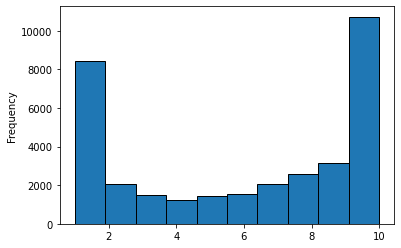

In [6]:
len(df['rating'].values)
df['rating'].plot(kind='hist', edgecolor='black')

In [7]:
# Remove 'neutral' scores (ratings of 5 and 6)
df = df[(df.rating > 6) | (df.rating < 5)]

<AxesSubplot:ylabel='Frequency'>

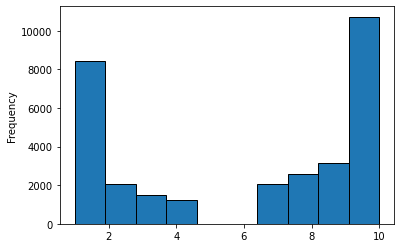

In [8]:
len(df['rating'].values)
df['rating'].plot(kind='hist', edgecolor='black')

In [9]:
# Remove unnecessary data (keeping review and rating)
df = df.drop(['movie','user','date','title'], axis=1)

In [10]:
df

,review,rating
0,Now I liked Sandra Bullock in the original Spe...,3
1,I was so curious as to what they would do in t...,2
2,Speed was a surprise hit movie. While it cost ...,3
3,Let the screenwriters and director go down wit...,3
4,After seeing THE best action movie ever (Speed...,1
...,...,...
9978,Amazing story performance it guides you the ho...,10
9979,Very good screenplay excellent performances an...,8
9980,I very like watching to movie. old movie and i...,10
9981,It's only the best movie ever. If anyone hasn'...,10


In [11]:
# Replace negative label with 1 and positive ratings with 0
df['rating'] = np.where(df['rating'] > 5, 0, 1)

<AxesSubplot:ylabel='Frequency'>

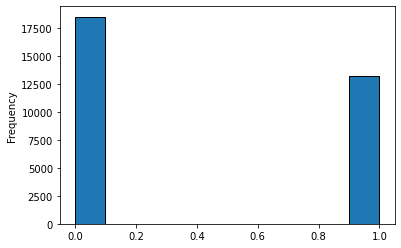

In [12]:
len(df['rating'].values)
df['rating'].plot(kind='hist', edgecolor='black')

In [13]:
# Inspect positive and negative counts
df['rating'].value_counts()

0    18556
1    13228
Name: rating, dtype: int64

In [14]:
df

,review,rating
0,Now I liked Sandra Bullock in the original Spe...,1
1,I was so curious as to what they would do in t...,1
2,Speed was a surprise hit movie. While it cost ...,1
3,Let the screenwriters and director go down wit...,1
4,After seeing THE best action movie ever (Speed...,1
...,...,...
9978,Amazing story performance it guides you the ho...,0
9979,Very good screenplay excellent performances an...,0
9980,I very like watching to movie. old movie and i...,0
9981,It's only the best movie ever. If anyone hasn'...,0


In [15]:
# Clean the data, convert to lowercase
df['review'] = df['review'].str.lower()

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    text=re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

df['review'] = df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

# Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

# Inspect results
df

,review,rating
0,now i liked sandra bullock in the original spe...,1
1,i was so curious as to what they would do in t...,1
2,speed was a surprise hit movie while it cost a...,1
3,let the screenwriters and director go down wit...,1
4,after seeing the best action movie ever speed ...,1
...,...,...
9978,amazing story performance it guides you the ho...,0
9979,very good screenplay excellent performances an...,0
9980,i very like watching to movie old movie and i ...,0
9981,its only the best movie ever if anyone hasnt s...,0


In [16]:
# Remove tags and links
tag = re.compile(r'<[^>]+>')
df['review'] = df['review'].apply(lambda x: tag.sub('', x))
df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www.\S+', '', regex=True).replace(r'http\S+', '', regex=True).replace(r'"', '', regex=True)


In [17]:
# Perform tokenization and lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(review):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(review)])

# Save changes to dataframe
df['review'] = df.review.apply(lemmatize_text).copy()

In [20]:
# Split dataset into train, text, and validation sets
x = pd.DataFrame(df, columns = ['review']) 
y = pd.DataFrame(df, columns = ['rating']) 

# Split dataset to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Split train dataset to train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", Y_test.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", Y_val.shape)

Shape of x_train:  (20341, 1)
Shape of y_train:  (20341, 1)
Shape of x_test:   (6357, 1)
Shape of y_test:   (6357, 1)
Shape of x_val:   (5086, 1)
Shape of y_val:   (5086, 1)


In [21]:
# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['review'].tolist()
val = X_val['review'].to_list()
test = X_test['review'].tolist()
STOPWORDS = set(stopwords.words('english'))

# Use 1000 features to improve score without crashing memory on Colab
tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = tfidfX_val.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: (20341, 1000)
TF-IDF test shape: (6357, 1000)
TF-IDF val shape: (5086, 1000)


In [22]:
# Convert X datasets to tensors.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_val = torch.tensor(tfidfX_val)
tfidfX_test = torch.tensor(tfidfX_test)

In [23]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

In [24]:
device = torch.device("cpu")

In [33]:
# Build model with 2 hidden layers
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        self.dropout = nn.Dropout(0.3)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [34]:
# Initialize model
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = 1
num_epochs = 10

# Define the model
model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(),lr=0.1e-3,weight_decay=1e-3)

# Transfer all the computation to CPU
model.to(device)
criterion = criterion.to(device)

In [ ]:
# This is a function that calculates the accuracy
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 256

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)

    print("Epoch:",epoch, "\n"
      "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
      "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

Epoch: 0 
Train_loss: 0.6801 Train Accuracy: 0.5802 
Validation_loss:   0.6561 Validation Accuracy:   0.5902 

Epoch: 1 
Train_loss: 0.5784 Train Accuracy: 0.7021 
Validation_loss:   0.4538 Validation Accuracy:   0.8624 

Epoch: 2 
Train_loss: 0.3573 Train Accuracy: 0.8794 
Validation_loss:   0.2959 Validation Accuracy:   0.8842 

Epoch: 3 
Train_loss: 0.2695 Train Accuracy: 0.8967 
Validation_loss:   0.2628 Validation Accuracy:   0.8924 

Epoch: 4 
Train_loss: 0.2466 Train Accuracy: 0.9037 
Validation_loss:   0.2536 Validation Accuracy:   0.895 

Epoch: 5 
Train_loss: 0.237 Train Accuracy: 0.9074 
Validation_loss:   0.2502 Validation Accuracy:   0.8956 



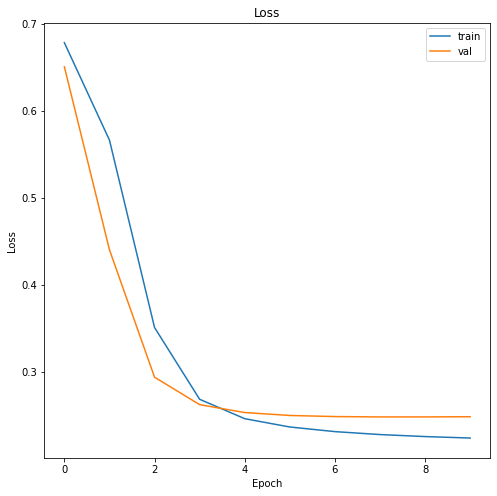

In [28]:
# Plot loss vs epochs
figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

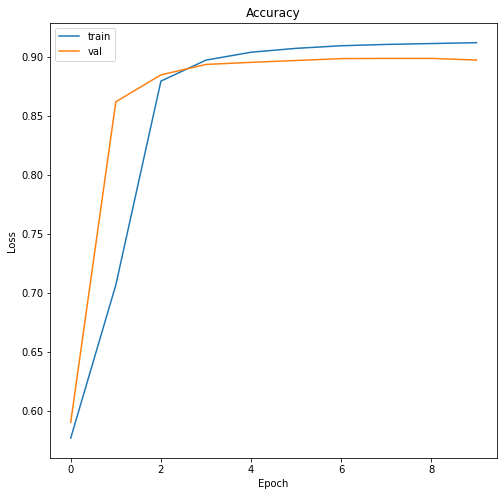

In [30]:
# Plot accuracy vs epochs
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.8952 



In [ ]:
# Show classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      3728
         1.0       0.87      0.87      0.87      2629

    accuracy                           0.90      6357
   macro avg       0.89      0.89      0.89      6357
weighted avg       0.90      0.90      0.90      6357

